In [5]:
#limpio la memoria
rm(list=ls())
gc()

#cargo librerias
library("data.table")
library("ROCR")
library("rpart")
library("rpart.plot")

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,717336,38.4,1333525,71.3,NA,1333525,71.3
Vcells,1337758,10.3,8388608,64.0,16384,2269767,17.4


In [6]:
setwd("~/cloudL/UA/labo2022/")

#Parametros entrada

#kcarpeta_datasets    <- "../input/laboratorio-de-implementacion-i-2021/"   #KAGGLE
kcarpeta_datasets    <- "./datasets/"                          #VM o Ubuntu

#Archivo con datos etiquetados para entrenamiento
karchivo_entrada      <-  paste0(kcarpeta_datasets, "competencia1_2022.csv")

#Formato para submit en Kaggle
#karchivo_score      <-  "../input/uamds2020ldi1f1/Sample_201910_Fase_I.txt"

#Separador de campos en archivos
kcampos_separador     <-  "\t"

#Campo que identifica las muestras
kcampo_id             <-  "numero_de_cliente"

#Campo que contiene la clase a estimar
kclase_nomcampo       <-  "clase_ternaria"

#Valor de interés
kclase_valor_positivo <-  "BAJA+2"

#Campos a borrar para el entrenamiento
kcampos_a_borrar      <-  c(kcampo_id,kclase_nomcampo,"foto_mes")

#Campo que contendrá a la variable objetivo generada
kobjetivo             <-  "clase"

#Identificación del modelo
kmodelo               <-  "02-RPART"

#Ganancia por TP
kTPGain               <-  78000

#Pérdida por FP
kFPGain               <-  -2000

#Establezco semilla aleatoria
set.seed(1)



In [7]:
#cargo los datos
dataset <- fread(karchivo_entrada)

dtrain  <- dataset[ foto_mes==202101 ]  #defino donde voy a entrenar
dapply  <- dataset[ foto_mes==202103 ]  #defino donde voy a aplicar el modelo


[1] 1.209457


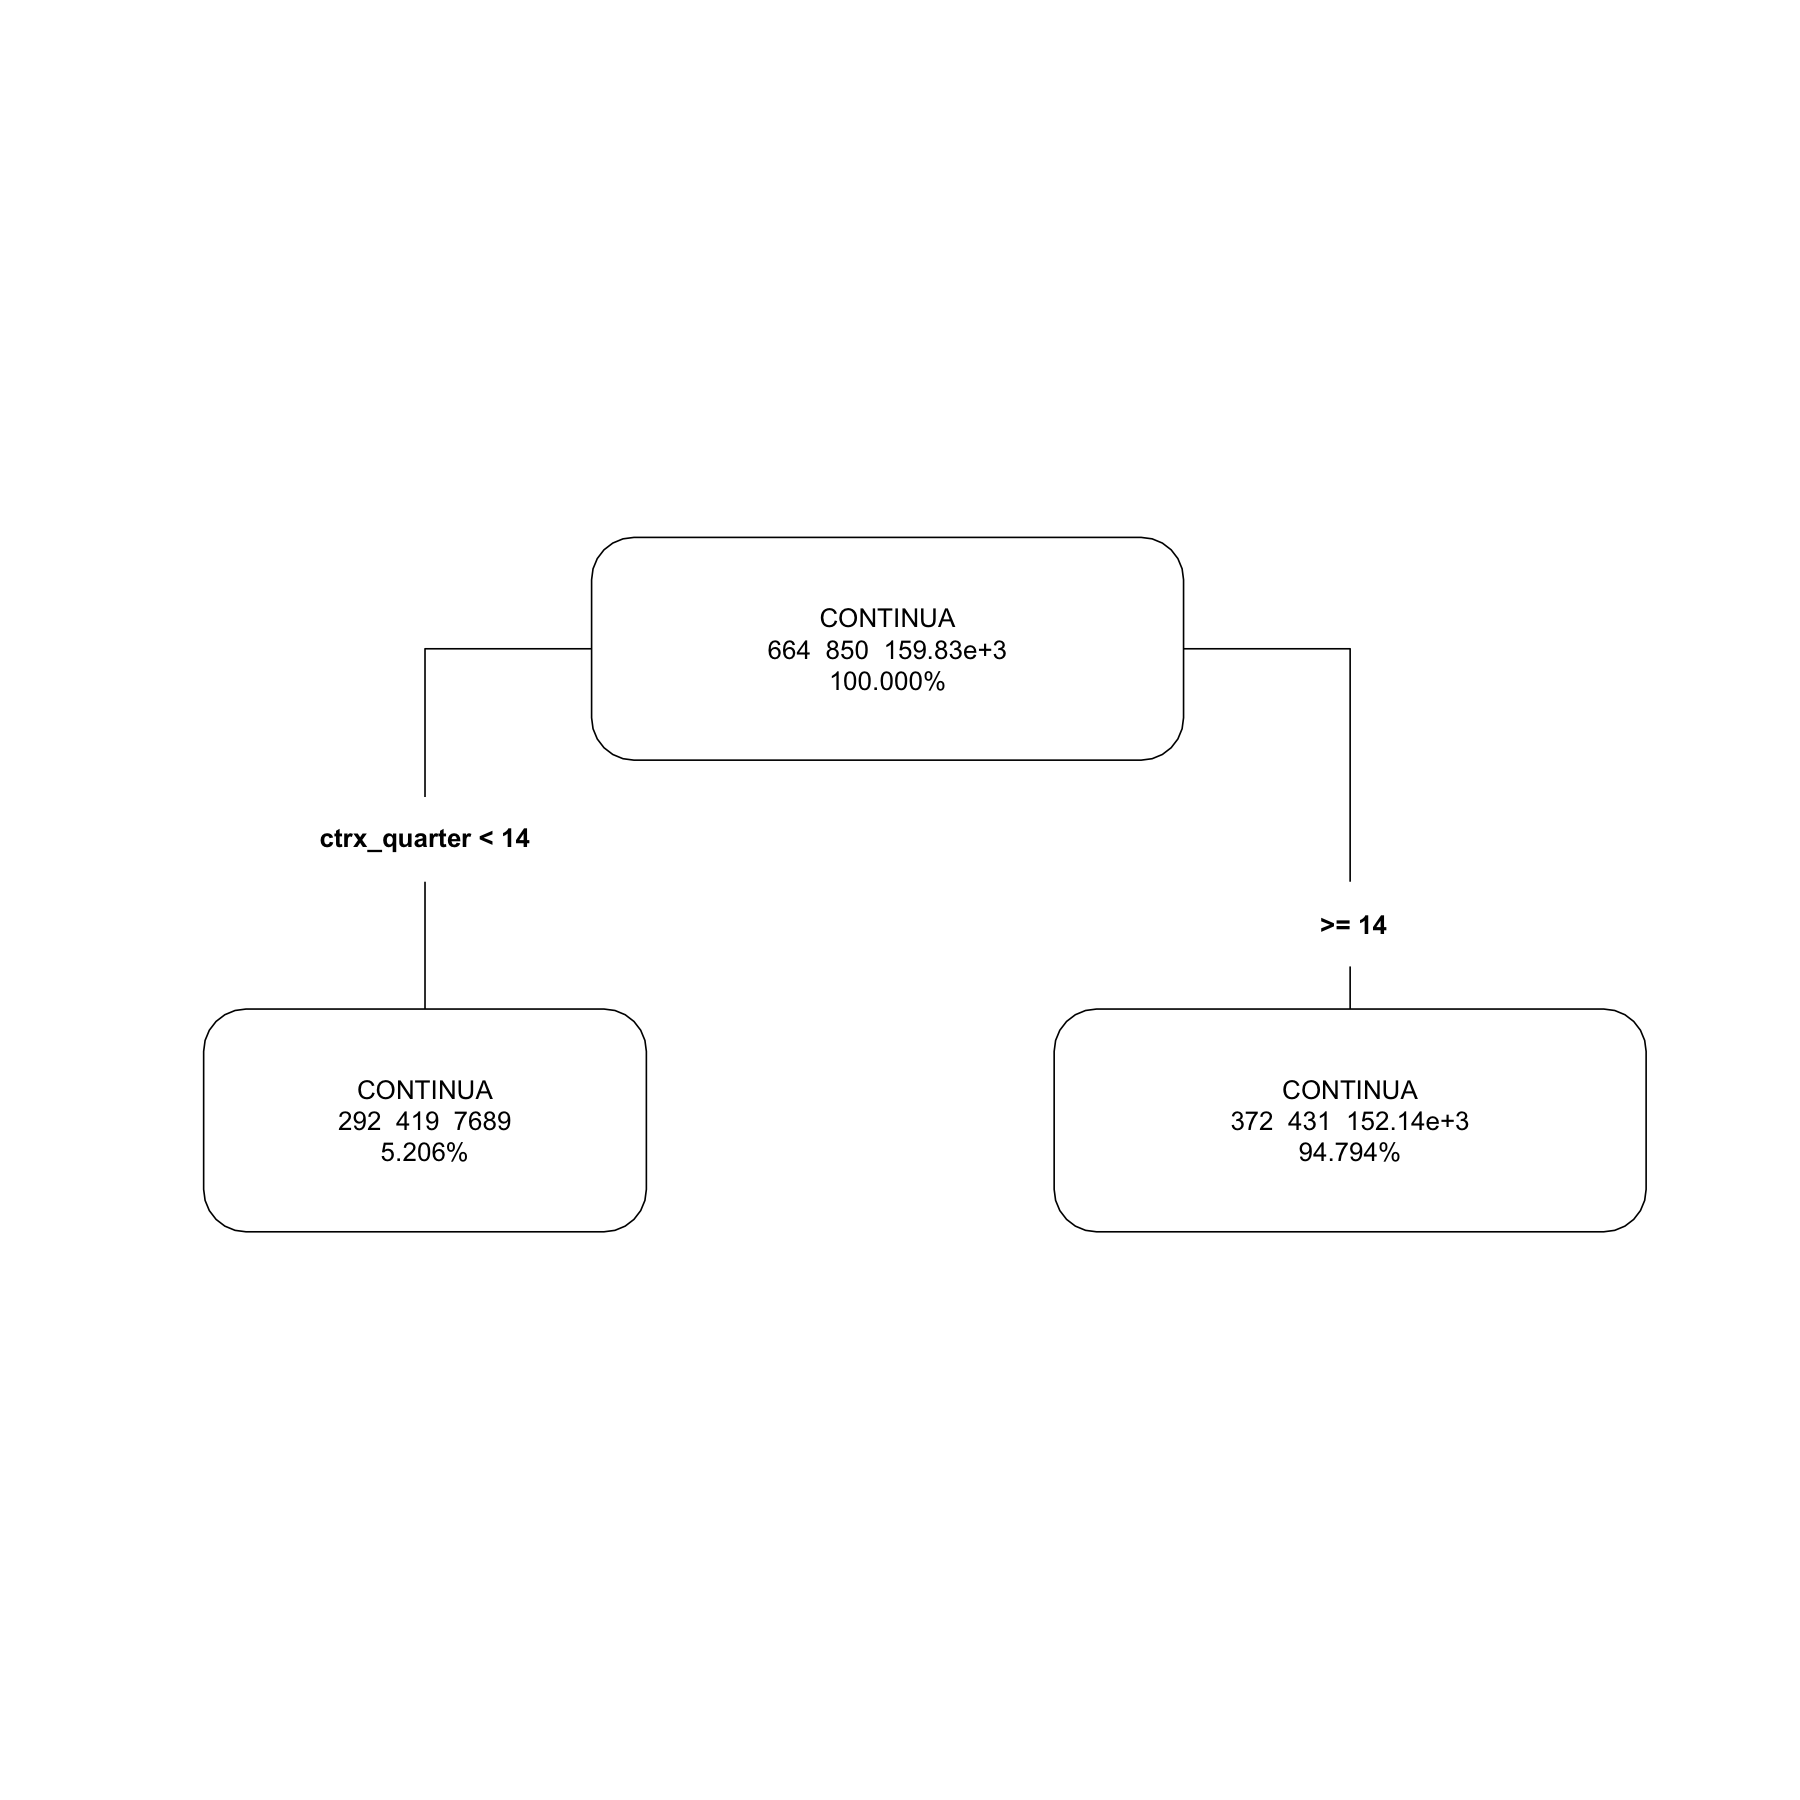

In [20]:
#Genero el modelo sobre dataset completo

t0       <-  Sys.time()
modelo   <-  rpart( "clase_ternaria ~ .", #quiero predecir clase_ternaria a partir de el resto de las variables
             data = dtrain,  #los datos donde voy a entrenar
             maxdepth=1, 
             cp = -0.3, 
             xval = 0)

t1       <-  Sys.time()

tcorrida <-  as.numeric( t1 - t0, units = "secs")
print( tcorrida)

#Arbol generado
options(repr.plot.width=15, repr.plot.height=15)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)

In [12]:
modelo

n= 161342 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 161342 1514 CONTINUA (0.004115481 0.005268312 0.990616207)  
  2) ctrx_quarter< 13.5 8400  711 CONTINUA (0.034761905 0.049880952 0.915357143) *
  3) ctrx_quarter>=13.5 152942  803 CONTINUA (0.002432295 0.002818062 0.994749644) *

In [13]:
prediccion  <- predict( modelo, dapply , type = "prob") #aplico el modelo

In [16]:
dapply[ , prob_baja2 := prediccion[, "BAJA+2"] ]

In [17]:
dapply[ , Predicted  := as.numeric(prob_baja2 > 1/40) ]

In [18]:
dir.create( "./exp/KA2002" )

Warning message in dir.create("./exp/KA2002"):
“'./exp/KA2002' ya existe”


In [19]:
fwrite( dapply[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
        file= "./exp/KA2002/KA2002_001.csv", 
        sep= "," )